## 2D transporter model - grid vs sampler comparison

In [ ]:
using Catalyst, DifferentialEquations, StatsPlots, Plots, DataFrames, CSV, Random, Turing, Latexify, ModelingToolkit, DynamicHMC
using ModelingToolkit: varmap_to_vars
using Optim, Noise, AdvancedMH, MCMCChains, StatsBase, Sundials
Random.seed!(14)
sigma_f = 1
t_short = false

# Normal log-likelihood calculation
function calc_norm_log_likelihood(mu,sigma,X)
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = length(X)
    f1 = -1*(n/2)*log(2*pi*sigma^2)
    f2_a = -1/(2*sigma^2)
    f2_b = 0 
    for i in 1:n
        f2_b += (X[i]-mu[i])^2
    end
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
end

# flux calculation function
function calc_flux(p,u,v)
    flux_in = v*(p[1]*u[1])
    flux_out = v*(p[2]*u[2].*u[3])
    net_flux = flux_in - flux_out         
end

# define reaction network in Catalyst
rn = @reaction_network begin
  (k1_f*H_out, k1_r), OF <--> OF_Hb
  (k2_f, k2_r), OF_Hb <--> IF_Hb
  (k3_f, k3_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k4_f, k4_r), IF_Hb_Sb <--> IF_Sb + H_in
  (k5_f, k5_r), IF_Sb <--> OF_Sb
  (k6_f, k6_r*S_out), OF_Sb <--> OF
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)

# define initial variable values and parameters
H_out_ref = 1e-7
S_out_ref = 1e-3
stdev_ref = sigma_f*1e-13
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r stdev_s
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) IF_Hb(t) IF_Hb_Sb(t) IF_Sb(t) OF_Sb(t)
u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, OF_Hb => 2.833e-8,  
        IF_Hb => 2.833e-8, IF_Hb_Sb => 2.833e-8,
        IF_Sb => 2.125e-8, OF_Sb => 2.125e-8, 
        ]
pmap = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

# create ODEproblem w/ timed events discrete callback
if t_short == true
    t_sample = 0.4
else
    t_sample = 0.04
end    
tspan1 = (0.0,15)
oprob = ODEProblem(odesys, u0map, tspan1, pmap)
event_times = [5.0,10.0]
condition(u,t,integrator) = t ∈ event_times
function affect!(integrator)
    if integrator.t == 5.0
        integrator.p[1] = 5e-8
    elseif integrator.t == 10.0
        integrator.p[1] = 1e-7
    end
end
cb = DiscreteCallback(condition,save_positions=(false, false), affect!)


# get y_true and y_obs
# s_true = solve(oprob, CVODE_BDF(), abstol = 1e-18, reltol = 1e-12, saveat=t_sample, callback=cb, tstops=event_times)
s_true = solve(oprob, TRBDF2(), abstol = 1e-12, reltol = 1e-9, saveat=t_sample, callback=cb, tstops=event_times)


k_true = [pmap[9][2], pmap[10][2]]
c_true = [s_true[IF_Hb_Sb], s_true[H_in], s_true[IF_Sb]]
vol = 0.0001
y_true = calc_flux(k_true,c_true,vol)


# y_obs = add_gauss(y_true,stdev_ref)
# df = DataFrame(data = y_obs)
# CSV.write("data_grid_test3.csv", df)
df2 = CSV.read("data_grid_test3.csv", DataFrame)
y_obs = df2[!, "data"]

ref_log_likelihood = calc_norm_log_likelihood(y_obs,stdev_ref,y_true)

println(length(y_obs))
println(ref_log_likelihood)
plot(y_true, ylim=(-1.5e-11, 1.5e-11));scatter!(y_obs)
##### end of 2D grid


┌ Info: Precompiling Catalyst [479239e8-5488-4da2-87a7-35f2df7eef83]
└ @ Base loading.jl:1423
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] do

┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107


┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107


┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107


┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Info: Skipping precompilation since __precompile__(false). Importing LoopVectorization [bdcacae8-1622-11e9-2a5c-532679323890].
└ @ Base loading.jl:1124
┌ Info: Precompiling VectorizationBase [3d5dd08c-fd9d-11e8-17fa-ed2836048c2f]
└ @ Base loading.jl:1423
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module JLLWrappers with build ID 417338442164768 is missing from the cache.
│ This may mean JLLWrappers [692b3bcd-3c85-4b1f-b108-f13ce0eb3210] does not support precompilation but is imported by a module that does.
└ @ Base loading.j

In [ ]:
using Sundials

##### 2d grid
Random.seed!(14)
println("2D grid...")

p_dict = Dict(
                "log_k1_f"=>[6.0,12.0,10.0],
                "log_k1_r"=>[-1.0,5.0,3.0],
                "log_k2_f"=>[-2.0,4.0,2.0],
                "log_k2_r"=>[-2.0,4.0,2.0],
                "log_k3_f"=>[3.0,9.0,7.0],
                "log_k3_r"=>[-1.0,5.0,3.0],
                "log_k4_f"=>[-1.0,5.0,3.0],
                "log_k4_r"=>[6.0,12.0,10.0],
                "log_k5_f"=>[-2.0,4.0,2.0],
                "log_k5_r"=>[-2.0,4.0,2.0],
                "log_k6_f"=>[-1.0,5.0,3.0],
             )

# p_dict = Dict(
#                 "log_k1_f"=>[6.0,12.0,10.0],
#                 "log_k1_r"=>[-1.0,5.0,3.0],
#                 "log_k2_f"=>[-2.0,4.0,2.0],
#                 "log_k2_r"=>[-2.0,4.0,2.0],
#                 "log_k3_f"=>[3.0,9.0,7.0],
#                 "log_k3_r"=>[-1.0,5.0,3.0],
#                 "log_k4_f"=>[-1.0,5.0,3.0],
#                 "log_k4_r"=>[6.0,12.0,10.0],
#                 "log_k5_f"=>[3.5,4.0,2.0],
#                 "log_k5_r"=>[3.5,4.0,2.0],
#                 "log_k6_f"=>[-1.0,5.0,3.0],
#              )

p_1 = "log_k1_f"
p_2 = "log_k1_r"
p_init = [p_dict[p_1][3], p_dict[p_2][3]] 



n_grid = 100
x1_range = LinRange(p_dict[p_1][1],p_dict[p_1][2],n_grid) # ref = 10
x2_range = LinRange(p_dict[p_2][1],p_dict[p_2][2],n_grid) # ref = 3


z = zeros(n_grid,n_grid) 
i_idx = 0
max_log_like = -Inf

for i in x1_range
    i_idx += 1
    j_idx = 0
    p_dict[p_1][3] = 1.0*i  
    
    for j in x2_range
        j_idx += 1
        p_dict[p_2][3] = 1.0*j

        # set parameter values and mapping
        sigma = sigma_f*1e-13
        log_k1_f = p_dict["log_k1_f"][3] # log10 rate constant (ref=1e10)
        log_k1_r = p_dict["log_k1_r"][3] # log10 rate constant (ref=1e3)  
        log_k2_f = p_dict["log_k2_f"][3] # log10 rate constant (ref=1e2)
        log_k2_r = p_dict["log_k2_r"][3] # log10 rate constant (ref=1e2)
        log_k3_f = p_dict["log_k3_f"][3] # log10 rate constant (ref=1e7) 
        log_k3_r = p_dict["log_k3_r"][3] # log10 rate constant (ref=1e3)  
        log_k4_f = p_dict["log_k4_f"][3] # log10 rate constant (ref=1e3) 
        log_k4_r = p_dict["log_k4_r"][3] # log10 rate constant (ref=1e10)
        log_k5_f = p_dict["log_k5_f"][3] # log10 rate constant (ref=1e2)
        log_k5_r = p_dict["log_k5_r"][3] # log10 rate constant (ref=1e2)
        log_k6_f = p_dict["log_k6_f"][3] # log10 rate constant (ref=1e3)
        log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
        pmap1 = [H_out => H_out_ref, S_out => S_out_ref,
                    k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
                    k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
                    k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
                    k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
                    k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
                    k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
                 ]

        # solve ODE system
        pnew = varmap_to_vars(pmap1, parameters(odesys))
        oprob1 = remake(oprob, p=pnew)
        #s_tmp = solve(oprob1, TRBDF2(), abstol = 1e-18, reltol = 1e-12, saveat=t_sample, callback=cb, tstops=event_times)
        s_tmp = solve(oprob1, TRBDF2(), abstol = 1e-18, reltol = 1e-12, saveat=t_sample, callback=cb, tstops=event_times)
        
        # calculate flux
        k_tmp = [pmap1[9][2], pmap1[10][2]]
        c_tmp = [s_tmp[IF_Hb_Sb], s_tmp[H_in], s_tmp[IF_Sb]]
        vol = 0.0001
        y_tmp = calc_flux(k_tmp,c_tmp,vol)
        #print(y_tmp)

        # calculate log-likelihood
        log_like_tmp = calc_norm_log_likelihood(y_obs,sigma,y_tmp)
        z[i_idx,j_idx] = log_like_tmp
        #println("$i $j $log_like_tmp")
        
        # update max log likelihood if needed
        if log_like_tmp > max_log_like
            max_log_like = log_like_tmp
        end
        
    end
end
println("grid max log likelihood: $max_log_like")
#heatmap(x1_range,x2_range,z, clim=(max_log_like-20, max_log_like),title = "log-likelihood grid of $p_2 vs $p_1")
heatmap(x1_range,x2_range,z, clim=(max_log_like-20, max_log_like),title = "log-likelihood grid of $p_1 vs $p_2")
plot!(size=(750,750))



In [22]:
#savefig("$p_1 $p_2 grid.png")

print(0.1*log10(5e-14), 0.1*log10(5e-13))

-1.3301029995663982-1.2301029995663981

In [50]:
using Catalyst, DifferentialEquations, StatsPlots, Plots, DataFrames, CSV, Random, Turing, Latexify, ModelingToolkit, DynamicHMC
using ModelingToolkit: varmap_to_vars
using Optim, Noise, AdvancedMH, MCMCChains, StatsBase, Sundials, Zygote


##### sampling
Random.seed!(14)
println("sampling...")
# create Turing model w/ forward differentiation
Turing.setadbackend(:forwarddiff)
@model function rxn_sampler(data, prob, sys)
    
    
    #log_k1_f ~ Uniform(6, 12)  # log10 rate constant (ref=1e10)
    #log_k1_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3)
    
    #log_k2_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    #log_k2_r ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    
    #log_k3_f ~ Uniform(3,9)  # log10 rate constant (ref=1e7) 
    #log_k3_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    
    #log_k4_f ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    #log_k4_r ~ Uniform(6, 12)  # log10 rate constant (ref=1e10)
    
    #log_k5_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    #log_k5_r ~ Uniform(-2,4)   # log10 rate constant (ref=1e2)
    
    #log_k6_f ~ Uniform(-1,5)  # log10  rate constant (ref=1e3)
    
    # set priors
    #stdev_sample2 = 1e-13
    
    #log_stdev_sample2 ~ Uniform(log10(5e-14), log10(5e-13))
    log_stdev_sample2 = log10(1e-13)
    
    log_k1_f ~ Uniform(6, 12) # log10 rate constant (ref=1e10)
    log_k1_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3)  
    
    log_k2_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k2_r ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    
    log_k3_f ~ Uniform(3,9)  # log10 rate constant (ref=1e7) 
    log_k3_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    
    log_k4_f ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_r ~ Uniform(6, 12)  # log10 rate constant (ref=1e10)
    
#     log_k4_f ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
#     log_k4_r ~ Uniform(6, 12)  # log10 rate constant (ref=1e10)
    
    log_k4_f = 3  # log10 rate constant (ref=1e3) 
    log_k4_r = 10  # log10 rate constant (ref=1e10)
    
    log_k5_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k5_r ~ Uniform(-2,4)   # log10 rate constant (ref=1e2)
    
    log_k6_f ~ Uniform(-1,5)  # log10  rate constant (ref=1e3)
    
    # set parameter values and initial concentrations
    log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
    pmap2 = [H_out => H_out_ref, S_out => S_out_ref,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
    ]
    
    # solve ODE system
    pnew2 = varmap_to_vars(pmap2, parameters(sys))
    oprob2 = remake(prob, p=pnew2)
    #sol2 = solve(oprob2, TRBDF2(), abstol = 1e-18, reltol = 1e-12, saveat=0.04, callback=cb, tstops=event_times)
    sol2 = solve(oprob2, TRBDF2(), abstol = 1e-16, reltol = 1e-12, saveat=0.04, callback=cb, tstops=event_times)
    
    
    # calc flux (y_pred)
    k2 = [pmap2[9][2], pmap2[10][2]]
    c2 = [sol2[IF_Hb_Sb], sol2[H_in], sol2[IF_Sb]]
    vol = 0.0001
    y_pred2 = calc_flux(k2,c2,vol)
    
    for i = 1:length(data)
        data[i] ~ Normal(y_pred2[i], 10^log_stdev_sample2)
    end
end
model = rxn_sampler(y_obs, oprob, odesys)
   
iterations = 2_000

#chain = mapreduce(c -> sample(model, NUTS(.65),iterations, init_params=p2), chainscat, 1:3)


# Generate a MLE estimate.
p_init = [
    log10(1.01e-13),
    10.01, 
    3.01, 
    2.01, 
    2.01, 
    7.01, 
    3.01, 
    3.01, 
    10.01, 
    2.01, 
    2.01, 
    3.01
]
println(p_init)
#mle_estimate = optimize(model, MLE(), NelderMead())  # Use NelderMead
#println(mle_estimate.values.array)

#chain = mapreduce(c -> sample(model, MH(), iterations), chainscat, 1:3)
#chain = mapreduce(c -> sample(model, MH(0.65), iterations, init_params=p_init), chainscat, 1:3)
chain = mapreduce(c -> sample(model, NUTS(0.45), iterations), chainscat, 1:3)

# max_lp = -Inf
# lp = chain[:lp]
# for i in 1:length(lp)
#     if lp[i]>max_lp
#         max_lp = lp[i]
#     end
# end    
# println(max_lp)

# ##### end of sampling
# MCMCChains.summarize(chain)


┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/georgeau/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
Sampling:  28%|███████████▌                             |  ETA: 3:53:51┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/georgeau/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 1:53:22
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/georgeau/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/georgeau/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected

sampling...
[-12.995678626217357, 10.01, 3.01, 2.01, 2.01, 7.01, 3.01, 3.01, 10.01, 2.01, 2.01, 3.01]
10717.93585105641


Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

    log_k1_f    9.8699    0.8212     0.0106    0.0851   14.5802    2.4294      ⋯
    log_k1_r    3.9757    0.5886     0.0076    0.0560   17.8730    1.7836      ⋯
    log_k2_f    2.8494    0.7868     0.0102    0.0844   14.0028    2.6454      ⋯
    log_k2_r    3.3545    0.2842     0.0037    0.0212   37.4077    1.2255      ⋯
    log_k3_f    7.2491    0.7230     0.0093    0.0711   18.0409    1.6935      ⋯
    log_k3_r    2.8668    0.9153     0.0118    0.0996   13.2342    3.2847      ⋯
    log_k4_f    1.3759    1.0639     0.0137    0.0578   78.8974    1.1111      ⋯
    log_k4_r    7.3462    1.4510     0.0187    0.1256   20.9462    1.5586      ⋯
    log_k5_f    2.8721    0.5245     0.0068    0.0595   12.1583    9.7041      ⋯
    log_k5_r    2.5589    1.0480     0.0135    0.1192   12.0443   24.6112      ⋯
    log_

In [ ]:
df = summarystats(chain)
# println(chain[p_1][1:3])
# println(chain[p_2][1:3])
CSV.write("julia_stats.csv", df)

In [ ]:
corner(chain, ylim=[p_dict[p_2][1],p_dict[p_2][2]], xlim=[p_dict[p_1][1],p_dict[p_1][2]], smooth=false, title="fullscale")
#savefig("$p_1 $p_2 sample_full_scale.png")
#marginalhist(chain)

#corner(chain)

In [49]:
corner(chain, smooth=false)
plot!(size=(1000,1000))
savefig("full_sample_auto_scale.png")

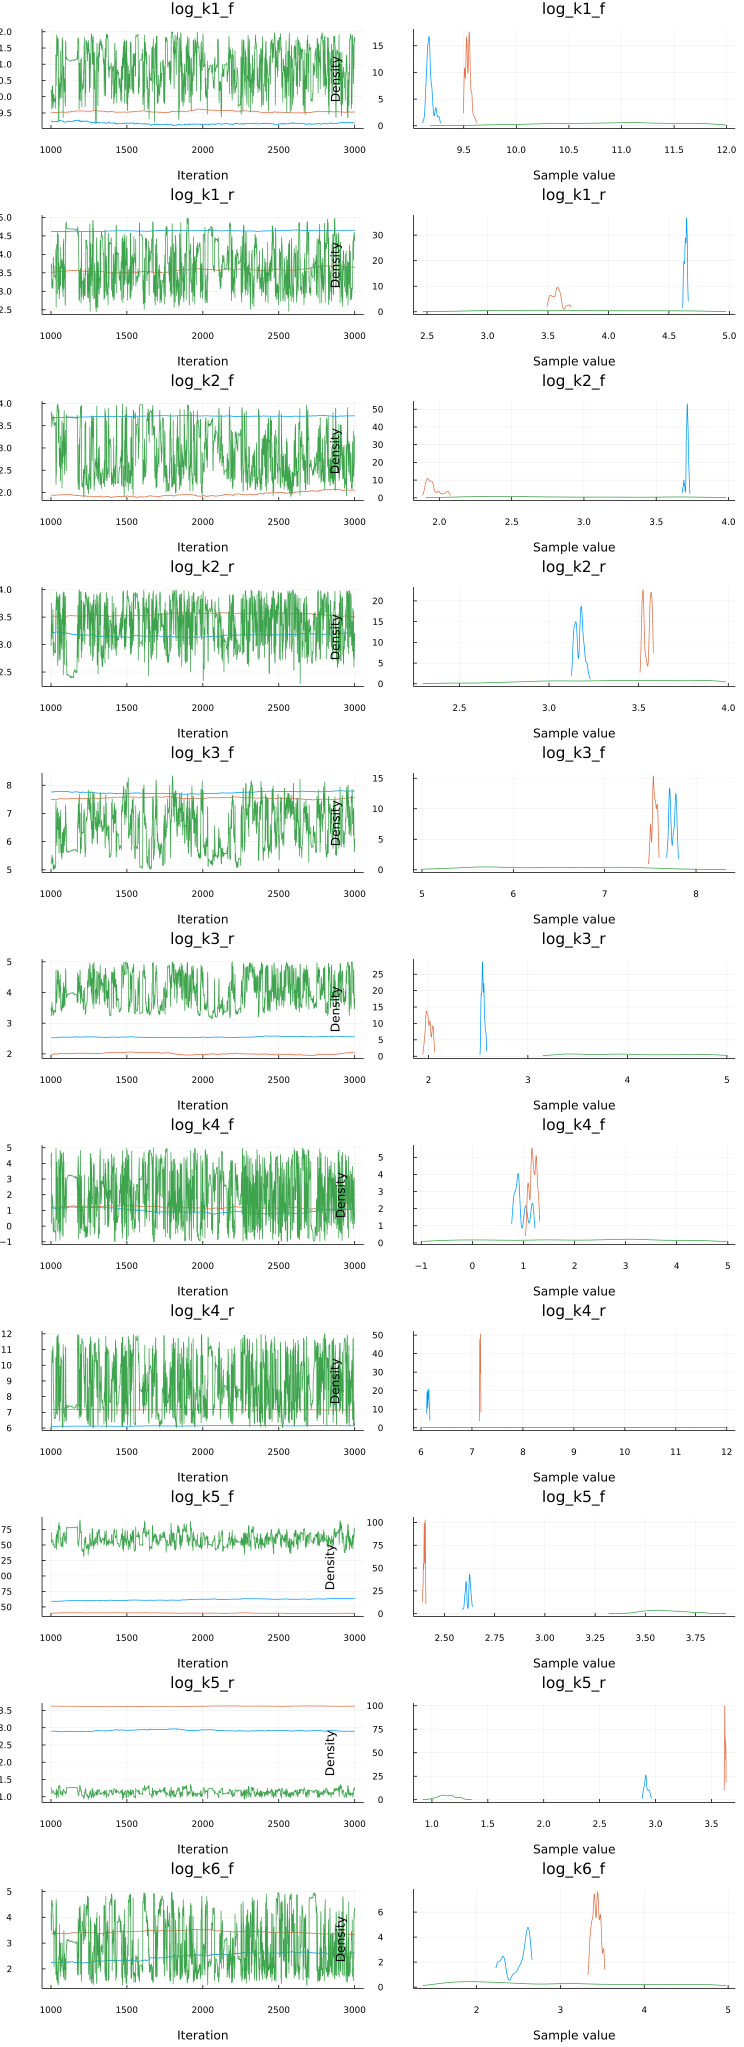

In [51]:
plot(chain)
#savefig("full_mcmc_traj.png")

In [48]:
plot(chain[:lp])
savefig("loglike_traj.png")

In [ ]:
# create empty grid - same dimensions as log-likelihood grid
x1_range2 = LinRange(p_dict[p_1][1],p_dict[p_1][2],n_grid)
x2_range2 = LinRange(p_dict[p_2][1],p_dict[p_2][2],n_grid)

z2 = zeros(n_grid,n_grid)
i_old = 0
i_cur = 0
j_old = 0
j_cur = 0

for i in x1_range2
    i_cur += 1
    j_curr = 0
    for j in x2_range2
        j_cur += 1
        if i > x1_range2[1] && j > x2_range2[1]
            for k in 1:length(chain[:log_k1_f])
                if ((x1_range2[i_old]<chain[:log_k1_f][k]) && (x1_range2[i_cur]>chain[:log_k1_f][k])) && ((x2_range2[j_old]<chain[:log_k1_r][k]) && (x2_range2[j_cur]>chain[:log_k1_r][k]))
                    z2[i,j] += 1.0
                end
            end
        end
        j_old = j_cur
    end
    i_old = i_cur
end
heatmap(x1_range2,x2_range2,z2)
plot!(size=(500,500))

In [ ]:
##### 2d grid
Random.seed!(14)
println("2D grid...")

p_dict = Dict(
                "log_k1_f"=>[6.0,12.0,10.0],
                "log_k1_r"=>[-1.0,5.0,3.0],
                "log_k2_f"=>[-2.0,4.0,2.0],
                "log_k2_r"=>[-2.0,4.0,2.0],
                "log_k3_f"=>[3.0,9.0,7.0],
                "log_k3_r"=>[-1.0,5.0,3.0],
                "log_k4_f"=>[-1.0,5.0,3.0],
                "log_k4_r"=>[6.0,12.0,10.0],
                "log_k5_f"=>[-2.0,4.0,2.0],
                "log_k5_r"=>[-2.0,4.0,2.0],
                "log_k6_f"=>[-1.0,5.0,3.0],
             )
p_1 = "log_k5_f"
p_2 = "log_k5_r"
p_init = [p_dict[p_1][3], p_dict[p_2][3]] 

 
p_dict[p_1][3] = 3.9393939393939394
p_dict[p_2][3] = 3.878787878787879

# set parameter values and mapping
sigma = sigma_f*1e-13
log_k1_f = p_dict["log_k1_f"][3] # log10 rate constant (ref=1e10)
log_k1_r = p_dict["log_k1_r"][3] # log10 rate constant (ref=1e3)  
log_k2_f = p_dict["log_k2_f"][3] # log10 rate constant (ref=1e2)
log_k2_r = p_dict["log_k2_r"][3] # log10 rate constant (ref=1e2)
log_k3_f = p_dict["log_k3_f"][3] # log10 rate constant (ref=1e7) 
log_k3_r = p_dict["log_k3_r"][3] # log10 rate constant (ref=1e3)  
log_k4_f = p_dict["log_k4_f"][3] # log10 rate constant (ref=1e3) 
log_k4_r = p_dict["log_k4_r"][3] # log10 rate constant (ref=1e10)
log_k5_f = p_dict["log_k5_f"][3] # log10 rate constant (ref=1e2)
log_k5_r = p_dict["log_k5_r"][3] # log10 rate constant (ref=1e2)
log_k6_f = p_dict["log_k6_f"][3] # log10 rate constant (ref=1e3)
log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
pmap1 = [H_out => H_out_ref, S_out => S_out_ref,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
         ]

println(log_k5_f)
println(log_k5_r)
println(log_k6_r)

println(pmap1[11])
println(pmap1[12])
println(pmap1[14])

# solve ODE system
pnew = varmap_to_vars(pmap1, parameters(odesys))
oprob1 = remake(oprob, p=pnew)
s_tmp = solve(oprob1, CVODE_BDF(), abstol = 1e-18, reltol = 1e-12, saveat=t_sample, callback=cb, tstops=event_times)

# calculate flux
k_tmp = [pmap1[9][2], pmap1[10][2]]
c_tmp = [s_tmp[IF_Hb_Sb], s_tmp[H_in], s_tmp[IF_Sb]]
vol = 0.0001
y_tmp = calc_flux(k_tmp,c_tmp,vol)


df_tmp = DataFrame(data = y_tmp, time=s_tmp[:t])
CSV.write("data_y_tmp.csv", df_tmp)

# calculate log-likelihood
log_like_tmp = calc_norm_log_likelihood(y_obs,sigma,y_tmp)
println("$log_like_tmp")

plot(vol*s_tmp[IF_Hb_Sb], label="IF_Hb_Sb");
plot!(vol*s_tmp[IF_Sb], label="IF_Sb")
plot!(vol*s_tmp[H_in], label="H_in")

# println()
# println(vol*s_tmp[H_in][1:2])
# println(vol*s_tmp[S_in][1:2])
# println(vol*s_tmp[OF][1:2])
# println(vol*s_tmp[OF_Hb][1:2])
# println(vol*s_tmp[IF_Hb][1:2])
println(vol*s_tmp[IF_Hb_Sb][1:3])
println(vol*s_tmp[IF_Sb][1:3])
println(vol*s_tmp[H_in][1:3])
println(k_tmp)

# println(vol*s_tmp[OF_Sb][1:2])

In [ ]:
plot(y_tmp, ylim=(-1.5e-11, 1.5e-11));scatter!(y_obs)

In [ ]:
latexify(odesys)

In [ ]:
vol = 0.0001

# OF = 2.833e-8 
# OF_Hb = 2.833e-8  
# IF_Hb = 2.833e-8 
# IF_Hb_Sb = 2.833e-8
# IF_Sb = 2.125e-8
# OF_Sb = 2.125e-8


OF = 8
OF_Hb = 7
IF_Hb = 6
IF_Hb_Sb = 5
IF_Sb = 4
OF_Sb = 3

H_in = 1e-7
S_in = 1e-3
H_out_ref = 1e-7
S_out_ref = 1e-3
H_out = H_out_ref
S_out = S_out_ref
k1_f =1e10
k1_r =1e3
k2_f =1e2
k2_r =1e2
k3_f =1e7
k3_r =1e3
k4_f =1e3
k4_r =1e10
k5_f =1e2
k5_r =1e2
k6_f =1e3
k6_r =1e7
        

dOF = k1_r*OF_Hb+k6_f*OF_Sb−H_out*k1_f*OF−S_out*k6_r*OF
dOF_Hb = (H_out*k1_f*OF)+(k2_r*IF_Hb)−(k1_r*OF_Hb)−(k2_f*OF_Hb)
dIF_Hb = k3_r*IF_Hb_Sb+k2_f*OF_Hb−k2_r*IF_Hb−k3_f*IF_Hb*S_in
dS_in = k3_r*IF_Hb_Sb−k3_f*IF_Hb*S_in
dIF_Hb_Sb = −k3_r*IF_Hb_Sb−k4_f*IF_Hb_Sb+k3_f*IF_Hb*S_in+k4_r*H_in*IF_Sb
dIF_Sb = k4_f*IF_Hb_Sb+k5_r*OF_Sb−k5_f*IF_Sb−k4_r*H_in*IF_Sb
dH_in = k4_f*IF_Hb_Sb−k4_r*H_in*IF_Sb
dOF_Sb = k5_f*IF_Sb+S_out*k6_r*OF−k5_r*OF_Sb−k6_f*OF_Sb


println(vol*dOF)
println(vol*dOF_Hb)
println(vol*dIF_Hb)
println(vol*dIF_Hb_Sb)
println(vol*dIF_Sb)
println(vol*dOF_Sb)
println(vol*dH_in)
println(vol*dS_in)